In [ ]:
# For M1 pro mac:

# First: 
# conda create --prefix ./envs python=3.9.23
# conda activate ./envs

# Then using pip:
# torch                     2.2.2
# torch-geometric           2.6.1

# Then using conda:
# shapely                   2.0.7
# scipy                     1.13.1
# scikit-learn              1.6.1
# pyproj                    3.6.1
# pillow                    11.3.0
# pandas                    2.3.3
# osmnx                     2.0.6
# numpy                     1.23.0
# matplotlib                3.9.4
# geopandas                1.0.1
# networkx                  3.2.1
# netCDF4                   1.7.2

# Then:
# conda install -c conda-forge dask-core=2023.4.0 datashader=0.14.4 flask=2.2.3 pygeos=0.14 flask-cors=6.0.1 geopy=2.4.1 pyrosm=0.6.2 osmium-tool=1.16.0 
# pip install spatialpandas==0.4.7 opencv-python==4.7.0.72 pyarrow==11.0.0 osmium==3.6.0 tensorflow-macos
# Then: 
# pip uninstall -y jax jaxlib
# pip install "protobuf==3.20.3" "Werkzeug==2.2.3"

In [ ]:
# For windows: we will create something like above!!
# ---------------------------------------------------

# conda create --prefix ./envs -c conda-forge dask-core=2023.4.0 datashader=0.14.4 flask=2.2.3 geopandas=0.12.2 ipykernel=6.19.2 matplotlib=3.7.1 numpy=1.23.5 pandas=2.0.0 python=3.9.16 pygeos=0.14 flask-cors=6.0.1 geopy=2.4.1 osmnx=1.9.4 pyrosm=0.6.2 osmium-tool=1.16.0 
# for windows extra: cudatoolkit=11.2.2 cudnn=8.1.0.77

# pip install spatialpandas==0.4.7 opencv-python==4.7.0.72 pyarrow==11.0.0 osmium==3.6.0
# for mac: pip install tensorflow-macos
# Another extra step for mac: python -m pip uninstall -y jax jaxlib
# for windows: pip install tensorflow-gpu==2.8.0
# python -m pip install "protobuf==3.20.3"
# python -m pip install "Werkzeug==2.2.3"

In [2]:
import pandas as pd
import geopandas as gpd
import spatialpandas as sp
import datashader as ds
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import pygeos
import math
import cv2
import dask
import platform
from shapely.geometry import box
from pyproj import Transformer

import datashader as ds
from datashader.core import bypixel
import os
os.environ['USE_PYGEOS'] = '0'

In [3]:
system = platform.system()
if system == "Darwin":
    current_dir = os.path.basename(os.getcwd())
    
    if current_dir != "backend":
        os.chdir(os.path.join(os.getcwd(), "backend"))

In [4]:
transformer = Transformer.from_crs(3395, 4326)
invtransformer = Transformer.from_crs(4326,3395)

In [5]:
def get_flat_coords_offset_arrays(arr):
    """
    Version for MultiPolygon data
    """
    # explode/flatten the MultiPolygons
    arr_flat, part_indices = pygeos.get_parts(arr, return_index=True)
    # the offsets into the multipolygon parts
    offsets1 = np.insert(np.bincount(part_indices).cumsum(), 0, 0)

    # explode/flatten the Polygons into Rings
    arr_flat2, ring_indices = pygeos.geometry.get_rings(arr_flat, return_index=True)
    # the offsets into the exterior/interior rings of the multipolygon parts 
    offsets2 = np.insert(np.bincount(ring_indices).cumsum(), 0, 0)

    # the coords and offsets into the coordinates of the rings
    coords, indices = pygeos.get_coordinates(arr_flat2, return_index=True)
    offsets3 = np.insert(np.bincount(indices).cumsum(), 0, 0)
    
    return coords, offsets1, offsets2, offsets3

def spatialpandas_from_pygeos(arr):
    coords, offsets1, offsets2, offsets3 = get_flat_coords_offset_arrays(arr)
    coords_flat = coords.ravel()
    offsets3 *= 2
    
    # create a pyarrow array from this
    _parr3 = pa.ListArray.from_arrays(pa.array(offsets3), pa.array(coords_flat))
    _parr2 = pa.ListArray.from_arrays(pa.array(offsets2), _parr3)
    parr = pa.ListArray.from_arrays(pa.array(offsets1), _parr2)
    
    return sp.geometry.MultiPolygonArray(parr)

def polygons(self, source, geometry, agg=None):
    from datashader.glyphs import PolygonGeom
    from datashader.reductions import any as any_rdn
    from spatialpandas import GeoDataFrame
    from spatialpandas.dask import DaskGeoDataFrame
    if isinstance(source, DaskGeoDataFrame):
        # Downselect partitions to those that may contain polygons in viewport
        x_range = self.x_range if self.x_range is not None else (None, None)
        y_range = self.y_range if self.y_range is not None else (None, None)
        source = source.cx_partitions[slice(*x_range), slice(*y_range)]
    elif isinstance(source, gpd.GeoDataFrame):
        # Downselect actual rows to those for which the polygon is in viewport
        x_range = self.x_range if self.x_range is not None else (None, None)
        y_range = self.y_range if self.y_range is not None else (None, None)
        source = source.cx[slice(*x_range), slice(*y_range)]
        # Convert the subset to ragged array format of spatialpandas
        geometries = spatialpandas_from_pygeos(source.geometry.array.data)
        source = pd.DataFrame(source)
        source["geometry"] = geometries
    elif not isinstance(source, GeoDataFrame):
        raise ValueError(
            "source must be an instance of spatialpandas.GeoDataFrame or \n"
            "spatialpandas.dask.DaskGeoDataFrame.\n"
            "  Received value of type {typ}".format(typ=type(source)))

    if agg is None:
        agg = any_rdn()
    glyph = PolygonGeom(geometry)
    return bypixel(source, self, glyph, agg)

ds.Canvas.polygons = polygons
cvs = ds.Canvas(plot_width=256, plot_height=256)

In [6]:
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = ((lon_deg + 180.0) / 360.0 * n)
    ytile = ((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

In [12]:
def elevation(filtered, bbox):
    proxy = pd.DataFrame({'height': 0, 'geometry': bbox}, index=[len(filtered)])
    proxy = gpd.GeoDataFrame(proxy)
    proxy.crs = '3395'

    clipped = gpd.clip(filtered, proxy)
    intersection = pd.concat([proxy, clipped], ignore_index=True)
    intersection = intersection[intersection.geom_type.isin(['Polygon', 'MultiPolygon'])]
    if len(intersection) > 0:
        intersection = sp.GeoDataFrame(intersection)
        values = cvs.polygons(intersection, geometry='geometry', agg=ds.max("height"))
    else:
        values = np.zeros((256,256))
    values = np.flipud(values)
    return values

def create_image(values, i, j, zoom, max_height, outputfolder):
    filename = '%s/%d/%d/%d.png'%(outputfolder,zoom,i,j)
    success = cv2.imwrite(filename, 255.0 * (values / max_height))
    if not success:
        raise Exception("Could not write image")
        
@dask.delayed
def compute_tile(gdf, i, j, zoom, max_height, outputfolder):
    bb0 = num2deg(i,j,zoom)
    bb1 = num2deg(i+1,j+1,zoom)
    bb0 = invtransformer.transform(bb0[0],bb0[1])
    bb1 = invtransformer.transform(bb1[0],bb1[1])
    bbox = box(bb0[0],bb0[1],bb1[0],bb1[1])
#     filtered = gdf.cx[bb0[0]:bb1[0],bb0[1]:bb1[1]]
    filtered = gdf.loc[gdf.sindex.intersection(bbox.bounds)]
    
    if len(filtered) > 0:
        values = elevation(filtered, bbox)
        create_image(values, i, j, zoom, max_height, outputfolder)
        
def compute_all(gdf, zoom, max_height, outputfolder):
    bounds = gdf.total_bounds
    lat0,lng0 = transformer.transform(bounds[0],bounds[1])
    lat1,lng1 = transformer.transform(bounds[2],bounds[3])
    coord0 = deg2num(lat0,lng0,zoom)
    coord1 = deg2num(lat1,lng1,zoom)
    bottomleft = [min(coord0[0],coord1[0]),min(coord0[1],coord1[1])]
    topright = [max(coord0[0],coord1[0]),max(coord0[1],coord1[1])]
    
    # Create folders (serial)
    for i in range(math.floor(bottomleft[0]),math.ceil(topright[0])):
        folder = '%s/%d/%d/'%(outputfolder,zoom,i)
        if not os.path.exists(folder):
            os.makedirs(folder)
    
    delayed = []
    for i in range(math.floor(bottomleft[0]),math.ceil(topright[0])):
        for j in range(math.floor(bottomleft[1]),math.ceil(topright[1])):
            ddelayed = compute_tile(gdf, i, j, zoom, max_height, outputfolder)
            delayed.append(ddelayed)
    dask.compute(*delayed)

In [27]:
def elevation(filtered, bbox):
    proxy = pd.DataFrame({'height': 0, 'geometry': bbox}, index=[len(filtered)])
    proxy = gpd.GeoDataFrame(proxy)
    proxy.crs = '3395'

    clipped = gpd.clip(filtered, proxy)
    intersection = pd.concat([proxy, clipped], ignore_index=True)
    intersection = intersection[intersection.geom_type.isin(['Polygon', 'MultiPolygon'])]
    if len(intersection) > 0:
        intersection = sp.GeoDataFrame(intersection)
        values = cvs.polygons(intersection, geometry='geometry', agg=ds.max("height"))
    else:
        values = np.zeros((256,256))
    values = np.flipud(values)
    return values

def create_image(values, i, j, zoom, max_height, outputfolder):
    filename = '%s/%d_%d.png'%(outputfolder,i,j)
    success = cv2.imwrite(filename, 255.0 * (values / max_height))
    if not success:
        raise Exception("Could not write image")
    

@dask.delayed
def compute_tile(gdf, i, j, zoom, max_height, outputfolder):
    bb0 = num2deg(i,j,zoom)
    bb1 = num2deg(i+1,j+1,zoom)
    bb0 = invtransformer.transform(bb0[0],bb0[1])
    bb1 = invtransformer.transform(bb1[0],bb1[1])
    bbox = box(bb0[0],bb0[1],bb1[0],bb1[1])
#     filtered = gdf.cx[bb0[0]:bb1[0],bb0[1]:bb1[1]]
    filtered = gdf.loc[gdf.sindex.intersection(bbox.bounds)]
    
    if len(filtered) > 0:
        values = elevation(filtered, bbox)
        create_image(values, i, j, zoom, max_height, outputfolder)
        
# @dask.delayed
def compute_all(gdf, zoom, max_height, outputfolder):
    bounds = gdf.total_bounds
    lat0,lng0 = transformer.transform(bounds[0],bounds[1])
    lat1,lng1 = transformer.transform(bounds[2],bounds[3])
    coord0 = deg2num(lat0,lng0,zoom)
    coord1 = deg2num(lat1,lng1,zoom)
    bottomleft = [min(coord0[0],coord1[0]),min(coord0[1],coord1[1])]
    topright = [max(coord0[0],coord1[0]),max(coord0[1],coord1[1])]

    delayed = []
    for i in range(math.floor(bottomleft[0]),math.ceil(topright[0])):
        for j in range(math.floor(bottomleft[1]),math.ceil(topright[1])):
            ddelayed = compute_tile(gdf, i, j, zoom, max_height, outputfolder)
            delayed.append(ddelayed)
    dask.compute(*delayed)

In [30]:
gdf = gpd.read_file("./data/served/vector/baselayer-0_buildings.geojson")
gdf = gdf.to_crs(epsg=3395)

In [32]:
compute_all(gdf, zoom=16, max_height=550, outputfolder="./data/served/raster/raster-tests")

In [ ]:
# Read a GeoJSON file

min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
# outputfolder = "./data/served/baselayer-0_buildings_raster/"

# os.makedirs(outputfolder, exist_ok=True)

z = 16

# (top-left)
x0, y0 = deg2num(max_lat, min_lon, z)
# (bottom-right)
x1, y1 = deg2num(min_lat, max_lon, z)

# Tile index ranges (inclusive)
min_x = math.floor(x0)   # left
max_x = math.ceil(x1)    # right
min_y = math.floor(y0)   # top
max_y = math.ceil(y1)    # bottom

# change gdf crs to 3395
gdf = gdf.to_crs(epsg=3395)

delayed = []
for i in range(min_x, max_x + 1):
    for j in range(min_y, max_y + 1):
        ddelayed = compute_tile(gdf, i, j, z, 550, outputfolder)
        delayed.append(ddelayed)
    
dask.compute(*delayed);

In [10]:
gdf = gpd.read_file("./data/served/vector/baselayer-0_buildings.geojson")


<Axes: >

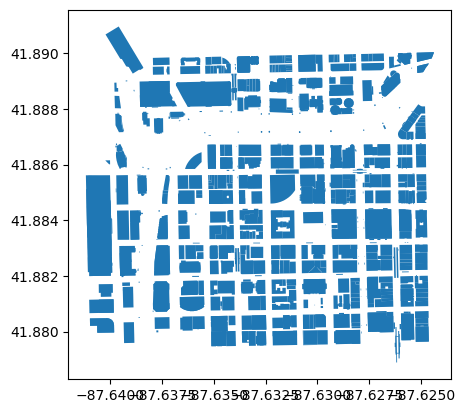

In [11]:
gdf.plot()

Tiles x: 16813..16816 (4), y: 24354..24357 (4)
Mosaic size (pixels): (1024, 1024)
Mosaic extent (lon/lat):
  west : -87.6434326171875
  east : -87.6214599609375
  south: 41.87774145109676
  north: 41.89409955811394


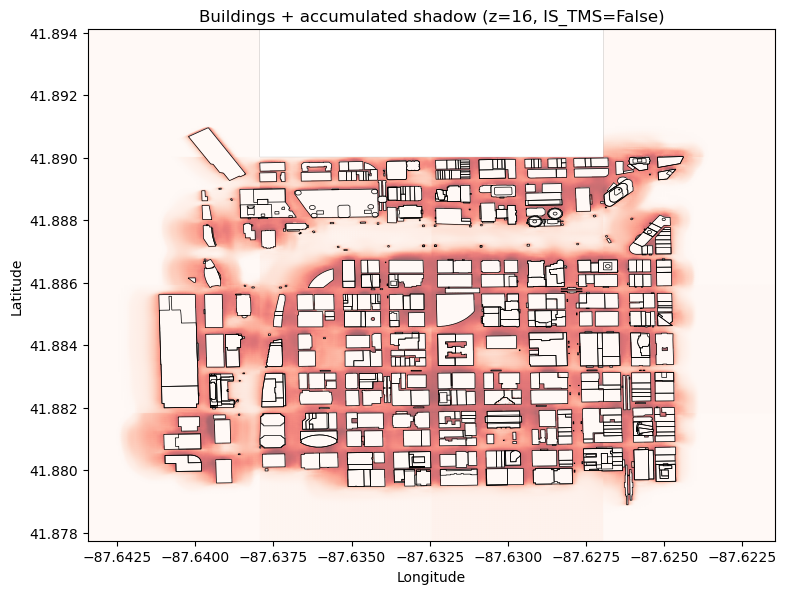

In [46]:
from pathlib import Path
from PIL import Image
import geopandas as gpd
import matplotlib.pyplot as plt
import math

# --- CONFIG --- #
BUILDINGS_PATH = "./data/served/vector/baselayer-0_buildings.geojson"          # adjust if needed
TILE_DIR = Path("./data/served/raster/acc-shadow-baselayer-0")     # folder with 16813_24354.png etc
Z = 16                                        # zoom level of the tiles
TILE_SIZE = 256                               # pixels
IS_TMS = False                                # try False first, then True if misaligned
# ------------- #

def tile2lon(x, z):
    return x / (2 ** z) * 360.0 - 180.0

def tile2lat(y, z):
    n = math.pi - (2.0 * math.pi * y) / (2 ** z)
    return (180.0 / math.pi) * math.atan(0.5 * (math.exp(n) - math.exp(-n)))

def tile_bounds(x, y, z, is_tms=False):
    """
    Returns (west, south, east, north) in lon/lat for a given tile.
    If is_tms=True, treats (x, y) as TMS indices and converts to XYZ.
    """
    if is_tms:
        n_tiles = 1 << z
        y = n_tiles - 1 - y   # TMS -> XYZ flip

    west  = tile2lon(x, z)
    east  = tile2lon(x + 1, z)
    north = tile2lat(y, z)
    south = tile2lat(y + 1, z)
    return west, south, east, north

# --- 1. Load buildings --- #
gdf = gpd.read_file(BUILDINGS_PATH)

# --- 2. Collect tile indices from filenames --- #
tile_files = sorted(TILE_DIR.glob("*.png"))
if not tile_files:
    raise RuntimeError(f"No PNG tiles found in {TILE_DIR}")

xs = []
ys = []
for f in tile_files:
    name = f.stem  # "16813_24354"
    x_str, y_str = name.split("_")
    xs.append(int(x_str))
    ys.append(int(y_str))

min_x, max_x = min(xs), max(xs)
min_y, max_y = min(ys), max(ys)

n_x = max_x - min_x + 1
n_y = max_y - min_y + 1

print(f"Tiles x: {min_x}..{max_x} ({n_x}), y: {min_y}..{max_y} ({n_y})")

# --- 3. Stitch tiles into one mosaic --- #
mosaic = Image.new("RGBA", (n_x * TILE_SIZE, n_y * TILE_SIZE))

for f in tile_files:
    name = f.stem
    x_str, y_str = name.split("_")
    x = int(x_str)
    y = int(y_str)

    tile = Image.open(f).convert("RGBA")

    col = x - min_x
    if not IS_TMS:
        # XYZ: y increases downward (north -> south)
        row = y - min_y
    else:
        # TMS: y increases upward (south -> north)
        # top row should be max_y
        row = max_y - y

    px = col * TILE_SIZE
    py = row * TILE_SIZE

    mosaic.paste(tile, (px, py))

print("Mosaic size (pixels):", mosaic.size)

# --- 4. Compute overall mosaic geographic bounds --- #
west_all, south_all, east_all, north_all = None, None, None, None

for f in tile_files:
    name = f.stem
    x_str, y_str = name.split("_")
    x = int(x_str)
    y = int(y_str)

    w, s, e, n = tile_bounds(x, y, Z, is_tms=IS_TMS)

    west_all  = w if west_all  is None else min(west_all,  w)
    south_all = s if south_all is None else min(south_all, s)
    east_all  = e if east_all  is None else max(east_all,  e)
    north_all = n if north_all is None else max(north_all, n)

print("Mosaic extent (lon/lat):")
print("  west :", west_all)
print("  east :", east_all)
print("  south:", south_all)
print("  north:", north_all)

# --- 5. Plot buildings + overlay mosaic --- #
fig, ax = plt.subplots(figsize=(8, 8))

# buildings in lon/lat (assuming GeoJSON is EPSG:4326)
gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

# overlay the stitched shadow mosaic
ax.imshow(
    mosaic,
    extent=(west_all, east_all, south_all, north_all),
    origin="upper",    # rows go top -> bottom
    alpha=0.6          # semi-transparent so you see buildings
)

ax.set_xlim(west_all, east_all)
ax.set_ylim(south_all, north_all)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Buildings + accumulated shadow (z={Z}, IS_TMS={IS_TMS})")
plt.tight_layout()
plt.show()


In [41]:
print("Mosaic size:", mosaic.size)  # sanity check


Mosaic size: (768, 1024)


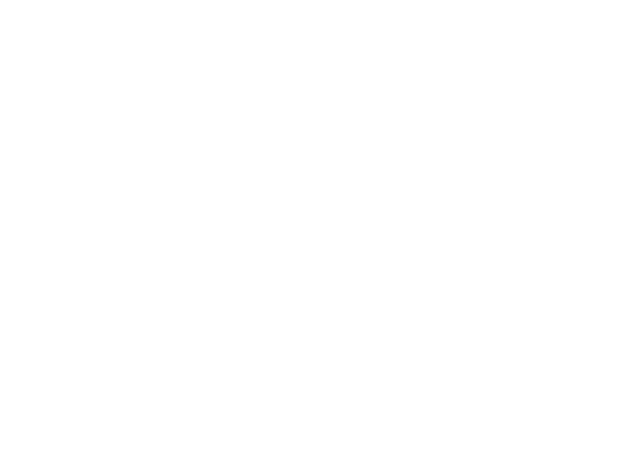

In [42]:
plt.axis("off")
plt.tight_layout()
plt.savefig("mosaic_debug.png", dpi=150, bbox_inches="tight")